In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
sys.path.append('.') # point to the root directory
ROOT_DIR = os.path.dirname(os.path.abspath('COMP_9417_23_Project')) # project Directory
data_dir = os.path.join(ROOT_DIR, 'data')
processed_data_dir = os.path.join(ROOT_DIR, 'data_pkl')

### A: Pre-process Data & Feature Engineering - EDA, Cleaning, Argumentation, Feature reduction and Selection
#### 1. Data Cleaning and Normarlization
Obtained data is clean and scaled, however, given that the ratio of features space to sample size is about 3:1,  argumentation may be applied increase sample size.

In [3]:
# Clean and prpepare data
file = os.path.join(data_dir, 'training.csv')
data_file =  pd.read_csv(file)

from utils import util
data = util.clean_outliers(data_file, drop_outliers = False )
X_train, X_test, y_train, y_test = util.prepare_data(data)

c:\Github\COMP_9417_23_Project\utils.py:178: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


Data preparation in progress...

Completed! - Files saved in c:\Github\COMP_9417_23_Project\data_pkl


##### 1.2. EDA- pairplot to view the Corr amongst response variables

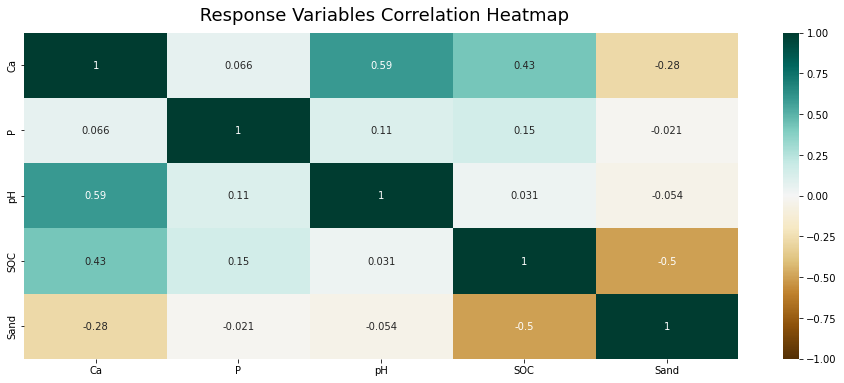

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(y_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(' Response Variables Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

#### 2. Feature Reduction/Selection

##### 2.1. PCA

In [4]:
# PCA
from sklearn.decomposition import PCA
from feature_select import FS
pca, top_features = FS.pca(X_train, explain_threshold=0.99)

In [5]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_test_pca

array([[-8.26917802,  2.3531852 , -1.21339871, ...,  0.05569799,
         0.29026126,  0.42397404],
       [ 5.34819182,  9.57779681,  1.98849547, ..., -0.59970919,
        -0.27431931, -0.34696385],
       [-5.84308463,  3.41622514, -0.38304646, ..., -0.98917447,
        -1.14039888, -0.15153324],
       ...,
       [-9.50902949, -2.57984665, -2.52347171, ..., -0.23392722,
         0.11666964,  0.18144635],
       [16.82646647,  1.67073443,  0.98941797, ...,  0.21860144,
         0.13735211, -0.35402322],
       [-8.03095345,  2.44318351,  1.91012395, ..., -0.19968842,
        -0.1600552 ,  0.31591754]])

In [6]:
print(np.sum(pca.explained_variance_ratio_))
PCA_matrix = pd.DataFrame(np.abs(pca.components_), columns=X_train.columns,
                          index=['PC-'+str(i) for i in range(1, len(pca.explained_variance_ratio_) + 1)])

df_train = pd.DataFrame(X_train_pca, columns=['PC-'+str(i) for i in range(1, X_train_pca.shape[1]+1)], 
                        index=[i for i in range(X_train_pca.shape[0])])
df_test = pd.DataFrame(X_test_pca, columns=['PC-'+str(i) for i in range(1, X_test_pca.shape[1]+1)])

0.9905099835343287


##### 2.2 Correlation Analyais:

In [11]:
from feature_select import FS
person, spearman = FS.pearson_corr_filtered(X_train, y_train, 0.1), FS.spearman_corr_filtered(X_train, y_train, 0.1)


Runing Pearson correlation for important features with correlations > 0.1 ...

3434 features selected for target: Ca
1582 features selected for target: P
1191 features selected for target: pH
3547 features selected for target: SOC
3547 features selected for target: Sand
Performance: 207.7054 seconds

Runing Pearson correlation for important features above 0.1 threshold...

3532 features selected for target: Ca
1833 features selected for target: P
1109 features selected for target: pH
3578 features selected for target: SOC
3558 features selected for target: Sand
Performance: 423.0163 seconds


##### 2.2.1: Plots showing Correlations btw predictors and response variable 

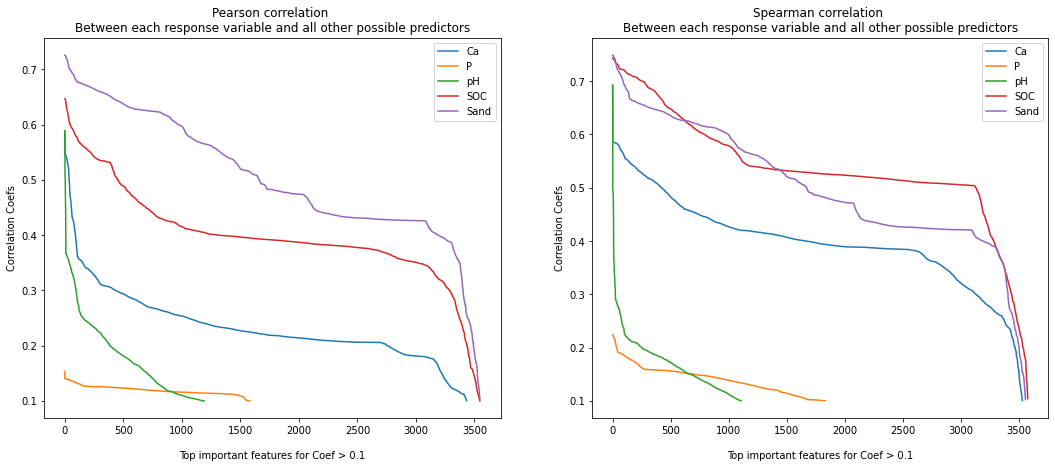

In [37]:
labels = list(y_train.columns)

# highlight/capture the relationship that exist between response variables
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# cor_features = [person, spearman]
for k in person.keys():
    ax[0].plot(range(len(person[k].index)), person[k].values)
    ax[0].legend(features)
    ax[0].set_title('Pearson correlation \nBetween each response variable and all other possible predictors')
    ax[0].set_ylabel('Correlation Coefs')
    ax[0].set_xlabel('\nTop important features for Coef > 0.1')
    
    # Captures the relationships between response variables for pearson Correletion 
    # for i in range(len(person[k].index)):
    #     if person[k].index[i] in labels:
    #         u = person[k].index[i] 
    #         v= round(person[k].values[i], 3)
    #         ax[0].text(i, v, '({}, {})'.format(u, v))
for k in spearman.keys():
    ax[1].plot(range(len(spearman[k].index)), spearman[k].values)
    ax[1].legend(features)
    ax[1].set_title('Spearman correlation \nBetween each response variable and all other possible predictors')
    ax[1].set_ylabel('Correlation Coefs')
    ax[1].set_xlabel('\nTop important features for Coef > 0.1')

    # Captures the relationships between response variables for spearson Correletion 
    # for i in range(len(spearman[k].index)):
    #     if spearman[k].index[i] in labels:
    #         u = spearman[k].index[i] 
    #         v= round(spearman[k].values[i], 3)
    #         ax[1].text(i, v, '({}, {})'.format(u, v))

plt.savefig('corr.png', dpi=300, bbox_inches='tight')
plt.show()

### B: Modeling
#### 3. Hyperparameter Tuning
##### 3.1. GridSearchCV methods + Search parameters and results imported + Tables to show results + validation plots

In [7]:
# Grid search completed and the pickle files imported
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
labels = list(y_train.columns)

##### 3.2. Models: Best parameters applied to build models + Model fit, Prediction + Train & test errors + Plots

**On Original Data**

**On PCA Transformed Data**


In [11]:
# Using PCA transformed Data
model2 = svm.SVR(C= 10000.0, coef0=0.01, degree=3, gamma="auto", kernel='poly')
y_hat2 = np.zeros(y_train.shape)
y_pred2 = np.zeros(y_test.shape)

y =np.array(y_train)
y_=np.array(y_test)

model2.fit(X_train_pca, y[:, 0])
model2s=[]
for i in range(5):
    mod = model2
    model2s.append(mod.fit(X_train_pca, y[:, i]).predict(X_train_pca))
   

SVR(C=10000.0, coef0=0.01, gamma='auto', kernel='poly')

In [15]:
er1 = mean_squared_error(y_[:, 0], y_pred2[:, 0], squared=False)
er1

0.4982482917147992

In [ ]:
# gbr_grid_search.fit(X_train_select, Y_train)
# best_model = gbr_grid_search.best_estimator_
# sorted_idx = best_model.feature_importances_.argsort()
# plt.barh(best_model.feature_names_in_[sorted_idx], best_model.feature_importances_[sorted_idx])
# plt.xlabel("Random forest feature importance")
# plt.show()

In [ ]:
# cols= X_train.columns[top_features]
# X_train[cols]
y_train.boxplot(column=list(y_train.columns), figsize=(18,10))
plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')

In [ ]:
import seaborn as sns
sns.pairplot(y_train, kind='reg')
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')

In [ ]:
sns.pairplot(X_no_outliers[list(X_no_outliers.columns[3585:3593])], kind='reg')

In [ ]:
xx.boxplot(column=list(xx.columns[3580:3585]), figsize=(18,10))

In [ ]:

# plt.figure(figsize =(15,5))
# plt.subplot(1,2,1)
# sns.lineplot(x=df['Job Start Date'], y=df['Rate in Rs./Kg.'], color='r')
# plt.title("Steel Scrap Rate (Rs/Kg)", fontsize=20)
# plt.xlabel('Date')
# plt.subplot(1,2,2)
# sns.lineplot(x=df['Job Start Date'], y=df['Scrape Sale Qty.'], color='b')
# plt.title("Steel Scrap Weight (Rs/Kg)", fontsize=20)
# plt.xlabel('Date')